In [1]:
import sklearn.datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

diabetes = sklearn.datasets.fetch_california_housing()
X, Y = diabetes["data"], diabetes["target"]
scaler.fit(X)
X = scaler.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [3]:
class SimpleRegressionElu(nn.Module):
    def __init__(self, input_dim=2, hidden_neurons=5, output_dim=3):
        super(SimpleRegressionElu, self).__init__()
        self.linear = nn.Linear(input_dim, hidden_neurons)
        self.linear1 = nn.Linear(hidden_neurons, int(hidden_neurons/2))
        self.linear2 = nn.Linear(int(hidden_neurons/2), int(hidden_neurons/2))
        self.linear_out = nn.Linear(int(hidden_neurons/2), output_dim)
        self.relu = nn.ReLU()
        self.elu = nn.ELU()
        self.sf = nn.Softmax()
        
    def forward(self, x):
        x = self.linear(x)        
        x = self.elu(x)
        x = self.linear1(x)        
        x = self.elu(x)
        x = self.linear2(x)        
        x = self.relu(x)
        x = self.linear_out(x)
        return x

In [4]:
X_train_ = torch.from_numpy(X_train).type(torch.FloatTensor)
y_train_ = torch.from_numpy(y_train).type(torch.FloatTensor)
X_test_ = torch.from_numpy(X_test).type(torch.FloatTensor)
y_test_ = torch.from_numpy(y_test).type(torch.FloatTensor)

In [5]:
import matplotlib.pyplot as plt

In [6]:
epochs = 100
batch_size = 100
steps = X_train_.shape[0] // batch_size
loss_func = nn.MSELoss()
plt_iter = 2

In [7]:
def weights_init(model):
    for m in model.modules():
        if isinstance(m, nn.Linear):
            # initialize the weight tensor, here we use a normal distribution
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)

49 completed, Loss 1.57334303855896 1.5711262226104736
99 completed, Loss 1.573350191116333 1.571075439453125


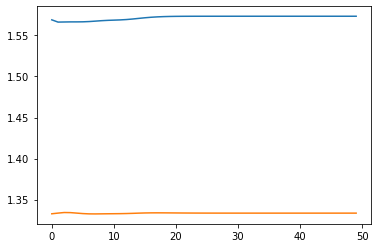

In [9]:
net = SimpleRegressionElu(input_dim=X.shape[1], output_dim=1, hidden_neurons=10)

def train(net):
    accuracy_list = []
    
    optimizer = torch.optim.Adam(net.parameters(), lr = 0.03)
    weights_init(net)
    all_losses = []
    all_test_loss = []
    for epoch in range(epochs):
        
        all_train_pred = np.zeros((X_train.shape[0], 1))
        current_loss = 0
        for i in range(steps):
            x_var = Variable(X_train_[i:i+batch_size], requires_grad=False)
            y_var = Variable(y_train_[i:i+batch_size], requires_grad=False)
            net.train()            
            yhat = net(x_var)
            loss = loss_func(yhat, y_var)            
            loss.backward()
            all_train_pred[i:i+batch_size] = yhat.detach().numpy().reshape(batch_size, 1)
            optimizer.step()
            optimizer.zero_grad()
            # Test loss
            #
            current_loss = (current_loss + loss)/2.0
        if epoch %  plt_iter == 0:
            all_losses.append(current_loss)
            val_losses = []
            net.eval()
            yhat = net(X_test_)
            loss = loss_func(yhat, y_test_)
            all_test_loss.append(loss)
        if (epoch+1) % 50 == 0:
            print(f"{epoch} completed, Loss {current_loss} {loss}")
            
    return all_losses, all_test_loss

all_losses, all_test_loss = train(net)
plt.plot(all_losses)
plt.plot(all_test_loss)